# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import wordsegment as ws
import tldextract as tld
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
from os import cpu_count

# custom modules
from code.util import *
from code.preprocessor import *
from code.gofaster import *

# parallelizer
gf = GoFaster(n_jobs=cpu_count()-1, n_partitions=cpu_count()*3)

# load wordsegment dictionary
ws.load()

# seaborn
sns.set()
sns.set_style("whitegrid")

# 1. Preprocessing

In [2]:
# Load data
data = load("data/urls.pkl")

## 1.1 Sampling
Take a random sample of 5% of normal urls and all phishing urls for a total of ~67k data points

In [3]:
sample = data[data.target==0].sample(frac=0.05, random_state=42)
sample = pd.concat([sample, data[data.target==1]]).reset_index(drop=True)
save(sample, "data/urls_sampled.pkl")

data = sample
print(len(data))

67690


## 1.2 Parsing

In [4]:
def parser(df):
    parse_result = data.url.apply(urlparse)
    
    df["scheme"] = parse_result.apply(lambda x: x.scheme)
    df["netloc"] = parse_result.apply(lambda x: x.netloc)
    df["path"] = parse_result.apply(lambda x: x.path)
    df["params"] = parse_result.apply(lambda x: x.params)
    df["query"] = parse_result.apply(lambda x: x.query)
    df["fragment"] = parse_result.apply(lambda x: x.fragment)
    
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, parser)

## 1.3 Domain Extraction
Separate netloc into subdomain, domain, and tld (top level domain)

In [5]:
def tldextracter(df):
    extract_result = df.netloc.apply(tld.extract)
    
    df["subdomain"] = extract_result.apply(lambda x: x.subdomain)
    df["domain"] = extract_result.apply(lambda x: x.domain)
    df["tld"] = extract_result.apply(lambda x: x.suffix)
    
    return df

if __name__ == "__main__":
    data = gf.parallelize(data, tldextracter)

## 1.4 Domain Segmentation
Segment domain into subwords based on wordsegment vocab

In [6]:
def segmenter(df):
    df["segments"] = df.domain.apply(ws.segment)
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, segmenter)

## 1.5 Concatenation

In [7]:
# concatenate path, params, query, and fragment
def cat(df):
    
    def worker(row):
        return row.path + row.params + row.query + row.fragment
        
    df["url_tail"] = df.apply(worker, axis=1)
    
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, cat)

In [8]:
# Finding leftover substrings after parsing
def scavenger(df):
    
    def worker(row):
        result = row.netloc

        for item in [row.subdomain, row.domain, row.tld]:
            result = result.replace(item, "", 1)

        return result.replace(".", "")
    
    df["leftovers"] = df.apply(worker, axis=1)
    
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, scavenger)

## 1.6 Additional Features

In [9]:
# counting special characters, subdomains etc.
def count_stuff(df):
    
    df['dots'] = df.url.apply(lambda x: x.count("."))
    df['hyphens'] = df.url.apply(lambda x: x.count("-"))
    df['ats'] = df.url.apply(lambda x: x.count("@"))
    df['slashes'] = df.url.apply(lambda x: x.count("/"))
    df['doubleslashes'] = df.url_tail.apply(lambda x: x.count("//"))
    df['queries'] = df.url.apply(lambda x: len(x.split("&")) if x else 0)
    df["len_url"] = df.url.apply(len)
    df["len_tail"] = df.url_tail.apply(len)
    
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, count_stuff)

---

In [10]:
# 2017~2019's top 20 most suspicious TLD and words
# https://www.symantec.com/blogs/feature-stories/top-20-shady-top-level-domains
suspicious_tlds = ['country','stream','download','xin','gdn','racing', 
                   'jetzt','win','bid','vip', 'ren', 'kim', 'loan',
                   'mom', 'party', 'review', 'trade', 'date', 'wang',
                   'accountants', 'zip','cricket','link','work','gq',
                   'science','tk', 'world', 'fit', 'work' 'ryukyu',
                   'life', 'cloud', 'desi', 'okinawa', 'ooo','men',
                   'click', 'loan', 'top', 'cf', 'ml', 'ga']

In [11]:
def suspicious(df):
    
    def worker(s, ls):
        for item in ls:
            if item in s:
                return 1
            
        return 0
    
    df["suspicious_tld"] = df.url.apply(lambda x: worker(x, suspicious_tlds))
    
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, suspicious)

---

In [12]:
data.head().T

,0,1,2,3,4
target,0,0,0,0,0
url,http://vioz.org,http://www.bwca.cc/wildflowers/flora.htm,http://www.appleseedenterprises.com/travel20.htm,http://www.soyouwanna.com/site/syws/kitchen/ki...,http://www.peterbelanger.com/newton.html
scheme,http,http,http,http,http
netloc,vioz.org,www.bwca.cc,www.appleseedenterprises.com,www.soyouwanna.com,www.peterbelanger.com
path,,/wildflowers/flora.htm,/travel20.htm,/site/syws/kitchen/kitchen.html,/newton.html
params,,,,,
query,,,,,
fragment,,,,,
subdomain,,www,www,www,www
domain,vioz,bwca,appleseedenterprises,soyouwanna,peterbelanger


In [13]:
save(data, "data/urls_preprocessed.pkl")

# 2. Visualization

## 2.1 URL Lengths

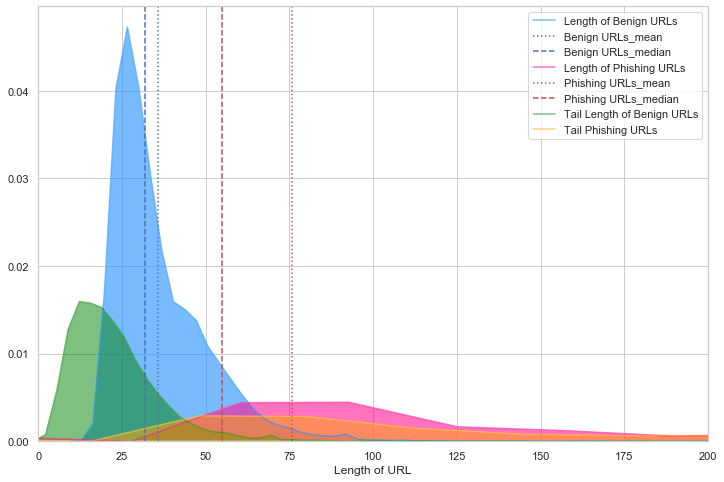

In [14]:
# Length of URL
plt.figure(figsize=(12, 8))
sns.kdeplot(data[data['target']==0]['len_url'],shade=True, color='dodgerblue', alpha=.6,label='Length of Benign URLs')
plt.axvline(np.mean(data[data['target']==0]['len_url']), c='b', ls=":", label="Benign URLs_mean")
plt.axvline(np.median(data[data['target']==0]['len_url']), c='b', ls="--", label="Benign URLs_median")
sns.kdeplot(data[data['target']==1]['len_url'],shade=True, color='deeppink',alpha=.6,label='Length of Phishing URLs')
plt.axvline(np.mean(data[data['target']==1]['len_url']), c='r', ls=":", label="Phishing URLs_mean")
plt.axvline(np.median(data[data['target']==1]['len_url']), c='r', ls="--", label="Phishing URLs_median")
sns.kdeplot(data[data['target']==0]['len_tail'],shade=True, color='green',alpha=.5,label='Tail Length of Benign URLs')
sns.kdeplot(data[data['target']==1]['len_tail'],shade=True, color='orange',alpha=.5,label='Tail Phishing URLs')
plt.legend(loc='upper right')
plt.xlim(0, 200)
plt.xlabel('Length of URL')
plt.show()

## 2.2 Feature Descriptions

In [15]:
data[data.target==0].describe()

,target,dots,hyphens,ats,slashes,doubleslashes,queries,len_url,len_tail,suspicious_tld
count,52429.0,52429.000000,52429.000000,52429.000000,52429.000000,52429.000000,52429.000000,52429.000000,52429.000000,52429.000000
mean,0.0,2.332392,0.178355,0.000286,3.476339,0.000610,1.020618,35.879933,10.359286,0.256328
std,0.0,0.670562,0.647447,0.018005,1.211324,0.024698,0.242485,14.661049,14.621541,0.436609
min,0.0,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,14.000000,0.000000,0.000000
25%,0.0,2.000000,0.000000,0.000000,3.000000,0.000000,1.000000,26.000000,1.000000,0.000000
50%,0.0,2.000000,0.000000,0.000000,3.000000,0.000000,1.000000,32.000000,1.000000,0.000000
75%,0.0,3.000000,0.000000,0.000000,4.000000,0.000000,1.000000,43.000000,18.000000,1.000000
max,0.0,10.000000,18.000000,2.000000,15.000000,1.000000,25.000000,441.000000,418.000000,1.000000


In [16]:
data[data.target==1].describe()

,target,dots,hyphens,ats,slashes,doubleslashes,queries,len_url,len_tail,suspicious_tld
count,15261.0,15261.000000,15261.000000,15261.000000,15261.000000,15261.000000,15261.000000,15261.000000,15261.000000,15261.000000
mean,1.0,2.545049,0.818754,0.029815,5.084726,0.018151,1.327960,75.852041,48.582072,0.338969
std,0.0,2.005894,1.648954,0.244659,2.222921,0.149699,1.331973,73.127572,71.727874,0.473375
min,1.0,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,12.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,0.000000,3.000000,0.000000,1.000000,38.000000,10.000000,0.000000
50%,1.0,2.000000,0.000000,0.000000,5.000000,0.000000,1.000000,55.000000,28.000000,0.000000
75%,1.0,3.000000,1.000000,0.000000,6.000000,0.000000,1.000000,86.000000,58.000000,1.000000
max,1.0,30.000000,29.000000,14.000000,30.000000,4.000000,24.000000,4096.000000,4065.000000,1.000000


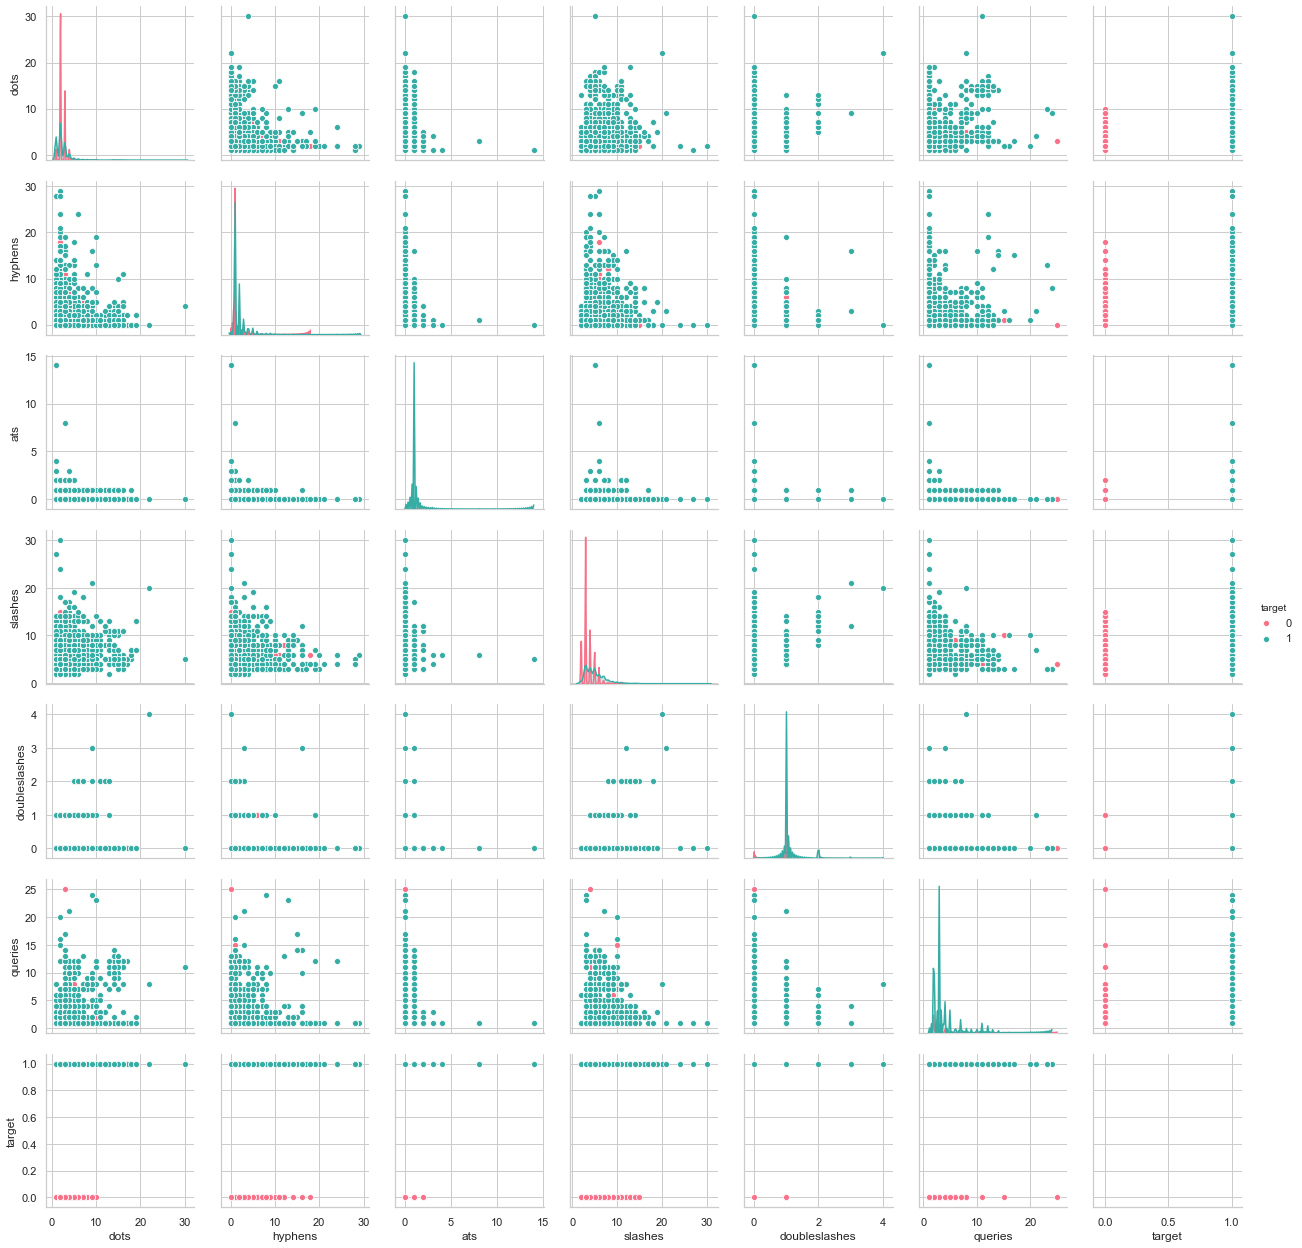

In [17]:
num_feat = data[['dots', 'hyphens', 'ats', 'slashes', 'doubleslashes','queries', 'target']]
sns.pairplot(num_feat, hue="target", palette="husl")

## 2.3 Scheme Distribution

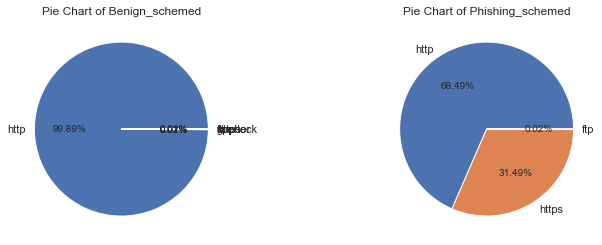

In [18]:
# FIXME
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax1,ax2 = ax.flatten()

# df0 = data[data.target==0].scheme.value_counts().to_frame()
# sns.barplot(x= df0['scheme'], y =df0.index, data = df0, orient='h', ax=ax1)
data[data.target==0].scheme.value_counts().plot.pie(autopct='%.2f%%', ax=ax1)
ax1.set_title('Pie Chart of Benign_schemed')
ax1.set_ylabel('')
ax1.set_xlabel('')

# df1 = data[data.target==1].scheme.value_counts().to_frame()
#sns.barplot(x= df1['scheme'], y =df1.index, data = df0, palette='plasma',orient='h', ax=ax2)
data[data.target==1].scheme.value_counts().plot.pie(autopct='%.2f%%', ax=ax2)
ax2.set_title('Pie Chart of Phishing_schemed')
ax2.set_ylabel("")
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.2);

## 2.4 Word Cloud

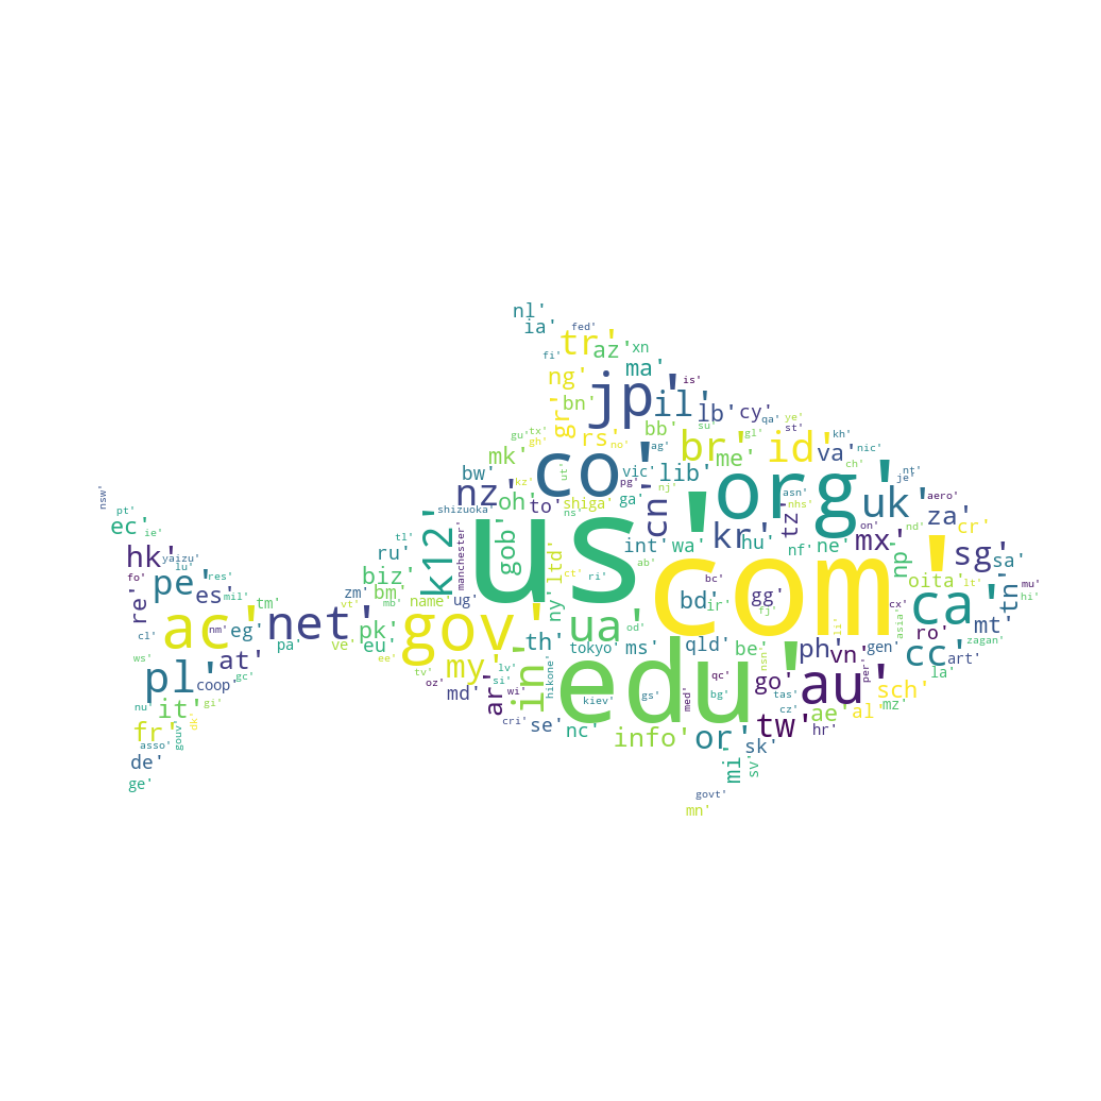

In [19]:
tld_word = data.tld.unique().tolist()

text = []
for w in tld_word:
    split_word = w.split('.')
    text.append(split_word)

text = str(text)

from PIL import Image 
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

img = Image.open("data/fish3.png")
img_matrix=np.array(img)
stopwords = set(STOPWORDS)

wc=WordCloud(background_color="white", mask=img_matrix, stopwords=stopwords)
wc.generate(text)

plt.figure(figsize=(40, 20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2.5 Character Discributions

In [20]:
def quantize(df):
    df["char"] = df.url_tail.apply(lambda x: char_level_encoder(x, pad=False))
    return df


if __name__ == "__main__":
    data = gf.parallelize(data, quantize)

In [21]:
benignchar = np.hstack(data[data.target==0].char)
phishchar = np.hstack(data[data.target==1].char)

In [22]:
from collections import Counter

In [23]:
benign_counts = Counter(benignchar)
phish_counts = Counter(phishchar)

In [24]:
benign_top = benign_counts.most_common(30)
phish_top = phish_counts.most_common(30)
x, y = map(list, zip(*benign_top))
x = list(map(chr, map(int, x)))

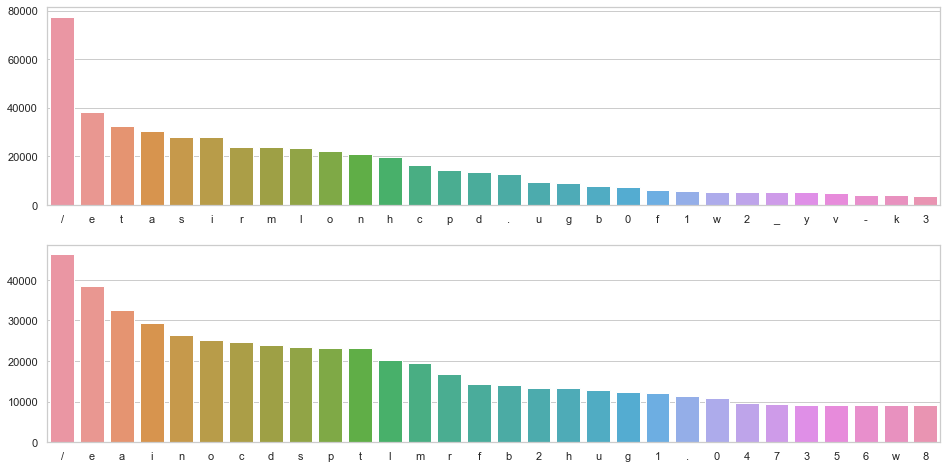

In [25]:
plt.figure(figsize=(16,8))

plt.subplot(211)
benign_top = benign_counts.most_common(30)
x1, y1 = map(list, zip(*benign_top))
x1 = list(map(chr, map(int, x1)))
sns.barplot(x1, y1)

plt.subplot(212)
phish_top = phish_counts.most_common(30)
x2, y2 = map(list, zip(*phish_top))
x2 = list(map(chr, map(int, x2)))
sns.barplot(x2, y2)

plt.show()

# 3. LogisticRegression

In [26]:
X = data[['dots', 'hyphens', 'ats', 'slashes', 'doubleslashes',
        'queries', 'len_url', 'len_tail', 'suspicious_tld',
       ]]
y = data.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=55)


from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

y_pred = LogReg.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[15270,   439],
       [ 2695,  1903]])

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     15709
           1       0.81      0.41      0.55      4598

    accuracy                           0.85     20307
   macro avg       0.83      0.69      0.73     20307
weighted avg       0.84      0.85      0.83     20307

